In [1]:
#%matplotlib qt
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
from ggplot import *
import datetime

In [59]:
turnstile_weather = pd.read_csv('./improved-dataset/turnstile_weather_v2.csv')

# 0. Calculate the difference between readings

In [103]:
turnstile_weather['Hours_difference'] = pd.to_datetime(turnstile_weather.TIMEn) - pd.to_datetime(turnstile_weather.TIMEn.shift())
turnstile_weather['Hours_difference'] = turnstile_weather.Hours_difference.astype('timedelta64[h]')

In [105]:
turnstile_weather['Hours_difference'] = turnstile_weather['Hours_difference'].map(lambda x: 24 + x if x < 0 else x).fillna(0)
pd.unique(turnstile_weather['Hours_difference'])

array([  0.,   4.,   8.,  12.,  20.,  16.])

In [113]:
turnstile_weather.groupby(['Hours_difference']).count()

,UNIT,DATEn,TIMEn,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,datetime,hour,day_week,...,pressurei,rain,tempi,wspdi,meanprecipi,meanpressurei,meantempi,meanwspdi,weather_lat,weather_lon
Hours_difference,,,,,,,,,,,,,,,,,,,,,
0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,40977,40977,40977,40977,40977,40977,40977,40977,40977,40977,...,40977,40977,40977,40977,40977,40977,40977,40977,40977,40977
8,1567,1567,1567,1567,1567,1567,1567,1567,1567,1567,...,1567,1567,1567,1567,1567,1567,1567,1567,1567,1567
12,70,70,70,70,70,70,70,70,70,70,...,70,70,70,70,70,70,70,70,70,70
16,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
20,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10


Mainly the gap between readings is 4 hours, but there are other different values. I've made other analysis to check the differences with more granularity (seconds), but with the dataset provided, those values are the only ones.

In this table we can see that the 4-hours-difference is the most common.

# 1. Differences between ENTRIESn_hourly

In [201]:
rain = turnstile_weather[turnstile_weather.rain == 1]
no_rain = turnstile_weather[turnstile_weather.rain == 0]
result1 = st.mannwhitneyu(rain.ENTRIESn_hourly, no_rain.ENTRIESn_hourly)
result1 # u-value, p-value

(153633768.5, 3.0537227760016002e-06)

In [202]:
if result1[1] < 0.05: print 'Reject the null'

Reject the null


## 1.1 If we sum the ENTRIESn_hourly for each UNIT (or station)

In [37]:
stations = turnstile_weather.groupby(['UNIT', 'rain'], as_index=False).sum()

In [203]:
rain_stations = stations[stations.rain == 1]
no_rain_stations = stations[stations.rain == 0]
result2 = st.mannwhitneyu(rain_stations.ENTRIESn_hourly, no_rain_stations.ENTRIESn_hourly)
result2 # u-value, p-value

(10320.0, 2.4832599666829287e-34)

In [204]:
if result2[1] < 0.05: print 'Reject the null'

Reject the null


We can see that if we separate the data between units, or even stations, the p-value obtained is much lower. How could we explain this difference?

Maybe if we analyze also the amount of water and not only whether or not is raining we could get better results. For example, if we analyze the amount of weather on each day of the month differentiating stations:

In [178]:
turnstile_weather['DAYn'] = turnstile_weather.datetime.map(lambda x: pd.to_datetime(x).day)

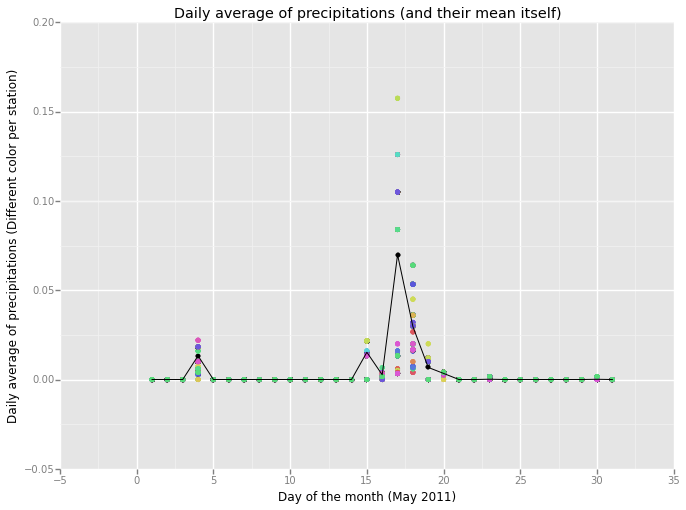

<ggplot: (282321721)>

In [179]:
mean_values = turnstile_weather[['DAYn','meanprecipi', 'meanpressurei', 'meantempi', 'meanwspdi']].groupby('DAYn').mean()
ggplot(mean_values.reset_index(), aes(x='DAYn', y='meanprecipi')) + \
    geom_point() + geom_line() + \
    geom_point(turnstile_weather, aes(x='DAYn', y='meanprecipi', color='station')) + \
    ggtitle("Daily average of precipitations (and their mean itself)") + \
    xlab("Day of the month (May 2011)") + \
    ylab("Daily average of precipitations (Different color per station)")

So there is a big difference in the the average precipitations for each station, which could give us the resulted p-value above.

# 2. Considering entries/hour instead ENTRIESn_hourly

As we've seen before, there is a difference in the time between readings. This difference could give us wrong results if we only take into account the ENTRIESn_hourly because it could include entries for 12 hours rather than 4.

So we're going to analyze if there is such a big difference and if we should use the number of entries per hour instead of the ENTRIESn_houly measurement.

In [206]:
turnstile_weather['entries_hour'] = (turnstile_weather.ENTRIESn_hourly / turnstile_weather.Hours_difference)
turnstile_weather = turnstile_weather.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

In [208]:
result3 = st.mannwhitneyu(rain.entries_hour, no_rain.entries_hour)
result3 # u-value, p-value

(153257362.0, 5.3762888392449422e-07)

In [209]:
if result3[1] < 0.05: print 'Reject the null'

Reject the null


At this point, the result is slightly better than the previous one (p-value = 2.74e-6).

In [171]:
stations = turnstile_weather.groupby(['UNIT', 'rain'], as_index=False).sum()

In [210]:
result4 = st.mannwhitneyu(rain_stations.entries_hour, no_rain_stations.entries_hour)
result4 # u-value, p-value

(10966.0, 4.1357779219907289e-32)

However, in the case of differentiating between units (or stations) the result is slightly worse (p-value = 2.54e-34).

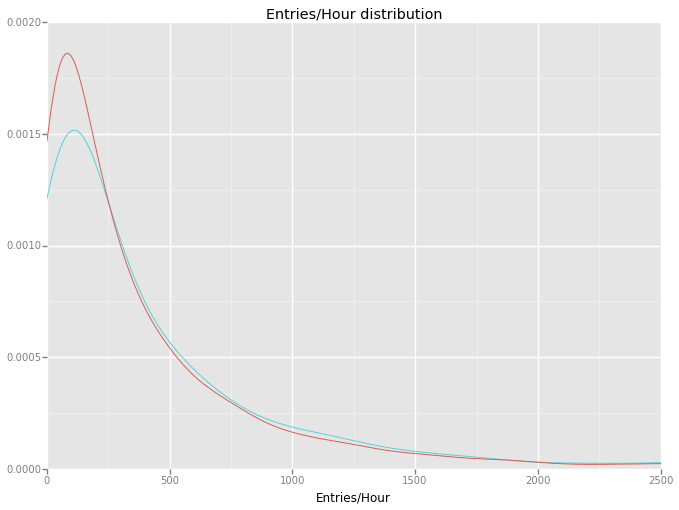

<ggplot: (286099357)>

In [219]:
ggplot(turnstile_weather, aes(x='entries_hour', color='rain')) + xlim(0, 2500) + geom_density() + ggtitle('Entries/Hour distribution') + xlab('Entries/Hour')

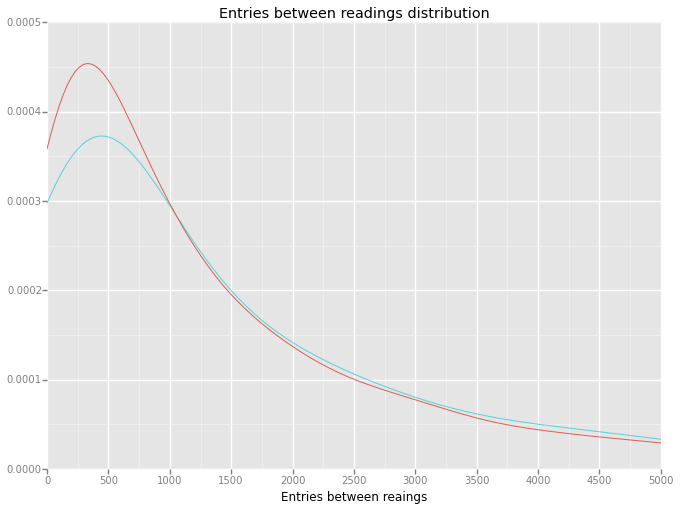

<ggplot: (283518417)>

In [221]:
ggplot(turnstile_weather, aes(x='ENTRIESn_hourly', color='rain')) + xlim(0, 5000) + geom_density() + ggtitle('Entries between readings distribution') + xlab('Entries between reaings')

# Effect Size

In [213]:
mean_difference1 = rain['ENTRIESn_hourly'].mean() - no_rain['ENTRIESn_hourly'].mean()
mean_difference1

181.86956604094553

In [214]:
cohensd1 = mean_difference1/np.sqrt(np.power(rain['ENTRIESn_hourly'].std(), 2) + np.power(no_rain['ENTRIESn_hourly'].std(), 2))
cohensd1

0.042333282394569668

# Considering the accumulated entries per day

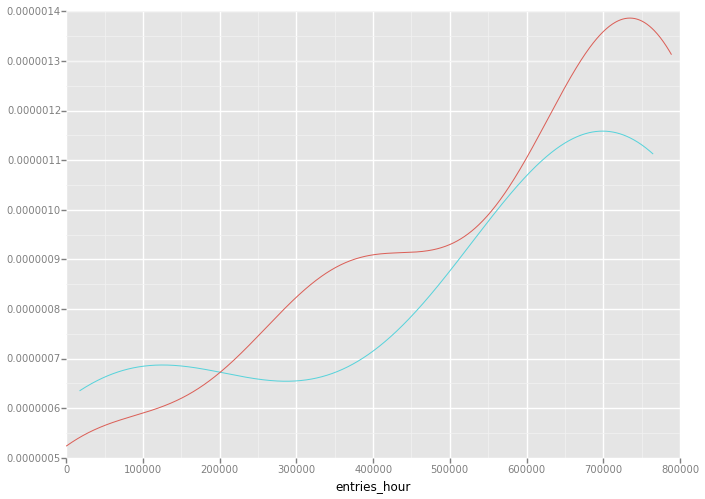

<ggplot: (286342993)>

In [236]:
entries_day = turnstile_weather.groupby(['DAYn', 'rain'], as_index=False).sum()
ggplot(entries_day, aes(x='entries_hour', color='rain')) + geom_density()

In [237]:
entries_day_rain = entries_day['entries_hour'][entries_day.rain == 1]
entries_day_no_rain = entries_day['entries_hour'][entries_day.rain == 0]
entries_result = st.mannwhitneyu(entries_day_rain, entries_day_no_rain)
entries_result

(137.0, 0.34810767562186995)